## Examples of optimization pathology and success in RL

The following notebook looks at the [hopper pybullet environment](https://github.com/benelot/pybullet-gym) pictured below 

![hopper env](hopperv1.png)

This agent was trained with stable baselines 3's implementation of PPO. The hyperparameters were set to the original paper's hyperparameters. The training distribution looks like this:

![train curve](generated_dirsbullet_evalhopper_resultscsv.png)

Notably, these evaluations are quite precise---all the variation you see are in fact real changes in the policy's quality. 

Our core question is: Why does the reinforcement learning process have so much variance? 

What we found is that the RL objective is profoundly non-smooth. This non-smoothness is so severe that the gradient can become misleading in many situations.

In [6]:
from reward_surfaces.experiments import generate_plane_data
from reward_surfaces.plotting import plot_plane
from reward_surfaces.runners.run_jobs_multiproc import run_job_list
from reward_surfaces.utils.job_results_to_csv import job_results_to_csv
from reward_surfaces.utils.surface_utils import readz, filter_normalize
from reward_surfaces.agents.make_agent import make_agent

import json
import os
import shutil
import torch

In [7]:
def plot_result(p_str, dir1_mag, dir2_mag, num_episodes=50, grid_size=11, max_eig=False):
    trained_checkpoint = f"train_hopper_small/{p_str}/"
    generated_dirs_dir = f"_temp_dir/"

    dir1_fname = f"hopper_grad/results/{p_str}/grad.npz"

    dir2_fname = f"{trained_checkpoint}/parameters.th"
    dir2 = [filter_normalize(v.cpu().detach().numpy()) for v in torch.load(dir2_fname,map_location=torch.device('cpu')).values()]

    dir1 = readz(dir1_fname)

    train_info = json.load(open(generated_dirs_dir+"info.json"))
    base_magnitude = 1.0
    dir1_mag = dir1_mag * base_magnitude
    dir2_mag = dir2_mag * base_magnitude
    dir1 = [d*dir1_mag/1000000 for d in dir1]
    dir2 = [d*dir2_mag for d in dir2]

    train_info['dir1_mag'] = dir1_mag
    train_info['dir2_mag'] = dir2_mag

    if os.path.exists(generated_dirs_dir):
        shutil.rmtree(generated_dirs_dir)
    print("removed")

    generate_plane_data(trained_checkpoint, generated_dirs_dir, dir1, dir2, train_info, grid_size=grid_size, num_episodes=num_episodes)
    run_job_list(generated_dirs_dir+"jobs.sh",disable_warnings=True)
    job_results_to_csv(generated_dirs_dir)
    plot_plane(generated_dirs_dir+"results.csv",
        outname="script_out",
        type="heat",
        dir1_name="Gradient offset",
        dir2_name="Random normalized offset",
        dir1_scale=dir1_mag,
        dir2_scale=dir2_mag,
        show=True
        )


How to interpret 

![](gradient_thingy_rand.png)

  9%|▉         | 11/121 [00:00<00:01, 101.59it/s]

removed


 99%|█████████▉| 120/121 [06:56<00:03,  3.47s/it]


(11, 11)


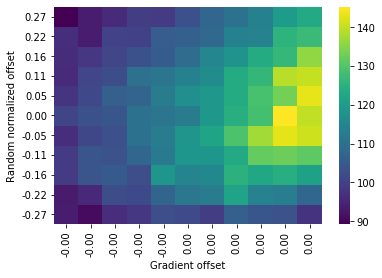

In [8]:
plot_result("0160000", 0.003, 0.3, num_episodes=200)

As you can see, if you zoom up, the policy gradient looks like a gradient

  8%|▊         | 10/121 [00:00<00:01, 99.03it/s]

removed


 99%|█████████▉| 120/121 [01:40<00:00,  1.19it/s]


(11, 11)


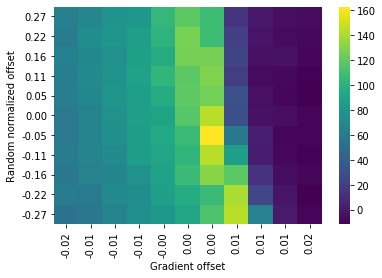

In [9]:
plot_result("0160000", 0.02, 0.3)

As you would expect, going in the direction of the graident is the shortest route to improving performance. However, if you follow the gradient even a little bit further, the value plumets to zero! Bizzarely, if you take a too big gradient step in the direction of the gradient, not even too far, just with an LR of 0.02, you end up with total policy collapse. You would have been better off stepping in the negative direction of the gradient. 

  8%|▊         | 10/121 [00:00<00:01, 90.77it/s]

removed


 99%|█████████▉| 120/121 [01:10<00:00,  1.70it/s]


(11, 11)


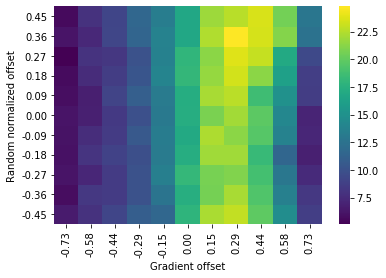

In [10]:
plot_result("0040000", 0.8, 0.5, num_episodes=200)

Early in training, when the objective is more smooth, the gradient direction smoothly increases and decreases, even for extremely large gradient steps.

  7%|▋         | 9/121 [00:00<00:01, 80.57it/s]

removed


 99%|█████████▉| 120/121 [02:29<00:01,  1.25s/it]


(11, 11)


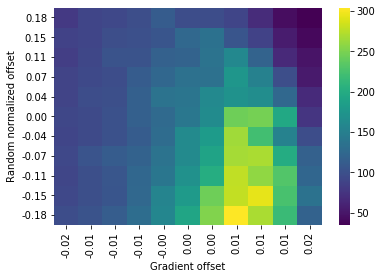

In [11]:
plot_result("0320000", 0.02, 0.2, num_episodes=50)

Later in training, when the objective is less convex, the objective quickly becomes this sharper, risker landscape, where the gradient direction is not necessarily best.

  8%|▊         | 10/121 [00:00<00:01, 92.02it/s]

removed


 99%|█████████▉| 120/121 [04:50<00:02,  2.42s/it]


(11, 11)


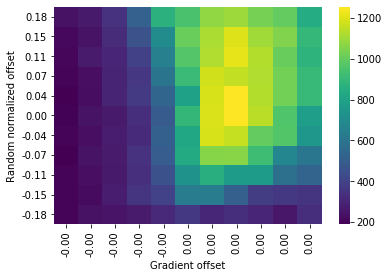

In [12]:
plot_result("2560000", 0.0005, 0.2, num_episodes=50)

Furthur along training, the objective gets another order of magnitude more sharp with the appropirate gradient size shrinking dramatically. 

  1%|          | 10/961 [00:00<00:09, 97.12it/s]

removed


100%|█████████▉| 960/961 [26:56<00:01,  1.68s/it]


(31, 31)


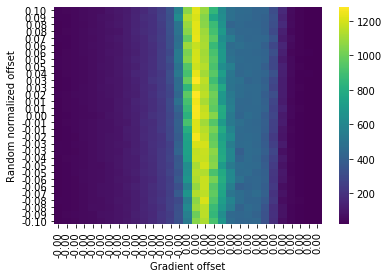

In [13]:
plot_result("2560000", 0.002, 0.10, num_episodes=50,grid_size=31,max_eig=True)

This view shows a very sharp line where the objective is high at around 1200 reward, with a stable platu aroun dit with reward at the 800 level. This helps explain why the oscelating reward in the training plot doesn't go beneath 800 -- there is a strong support of that reward in the policy space. 